In [11]:
from openai import OpenAI
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('seaborn-v0_8')

In [2]:
with open('openai_api_key.py') as script:
    exec(script.readline())

client = OpenAI(
  api_key=openai_api_key,
)

In [13]:
def run_experiment(model, prompt, instruction, temperature, n, max_tokens=1):
    answers = []
    for _ in range(n):
        response = client.chat.completions.create(
            model=model,  
            messages=[
                {"role": "system", "content": instruction},

                {"role": "user", "content": prompt}
            ],
            max_tokens=max_tokens,
            temperature=temperature
        )

        # Store the answer in the list
        answer = response.choices[0].message.content
        answers.append(answer.strip())
        
        # Add delay before the next API call
        if model == 'gpt-3.5-turbo-1106':
            # 3500 requests per minute
            time.sleep(60/3500)
        else:
            # 500 requests per minute
            time.sleep(60/500)
            
        progress_bar.update(1)

    return answers

# Experiment

People will be risk-averse for gains, but risk-seeking for losses. The percentage of subjects choosing each option is shown in brackets.

Problem 1: You are offered a choice between

A: A sure gain of `$100`. (*72%*)

B: A `50%` chance to gain `$200` and a `50%` chance to lose `$0`. (*28%*)

Problem 2: You are offered a choice between

A: A sure loss of `$100`. (*36%*)

B: A `50%` chance to lose `$200` and a `50%` chance to lose `$0`. (*64%*)

From

- Thaler, Richard (2015), "Misbehaving"

In [21]:
prompt1 = """You are offered two choices. Which choice would you prefer?

A: A sure gain of $100.
B: A 50% chance to gain $200 and a 50% chance to lose $0."""

prompt2 = """You are offered two choices. Which choice would you prefer?

A: A sure loss of $100.
B: A 50% chance to lose $200 and a 50% chance to lose $0."""

In [22]:
prompts = [prompt1, prompt2]

models = ['gpt-4-1106-preview', 'gpt-3.5-turbo-1106']

instruction = 'Please answer by only giving the letter of the answer option A or B.'

In [23]:
results_list = []
answers_storage = []

n = 100

progress_bar = tqdm(range(len(models) * len(prompts) * n))

for model in models:
    for i, prompt in enumerate(prompts):
        
        answers = run_experiment(model, prompt, instruction, temperature=1, n=n)
        
        a_share = answers.count('A') / len(answers)
        b_share = answers.count('B') / len(answers)

        results = [model, (i+1), a_share, b_share]
        
        answers_storage.append(answers)
        results_list.append(results) 

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [28:45<00:00,  2.25s/it]

In [24]:
columns = ['Model', 'Prompt', 'A', 'B']

df = pd.DataFrame(results_list, columns=columns)
df

,Model,Prompt,A,B
0,gpt-4-1106-preview,1,0.94,0.06
1,gpt-4-1106-preview,2,0.08,0.92
2,gpt-3.5-turbo-1106,1,0.04,0.96
3,gpt-3.5-turbo-1106,2,0.00,1.00


In [56]:
# Results from the real experiment
real_experiment_results = pd.DataFrame({
    'Model': 'Real Experiment',
    'Prompt': [1, 2],
    'A': [0.72, 0.36],
    'B': [0.28, 0.64]
})

# Concatenate the real experiment results to the existing DataFrame
df = pd.concat([df, real_experiment_results], ignore_index=True)
df

,Model,Prompt,A,B
0,gpt-4-1106-preview,1,0.94,0.06
1,gpt-4-1106-preview,2,0.08,0.92
2,gpt-3.5-turbo-1106,1,0.04,0.96
3,gpt-3.5-turbo-1106,2,0.00,1.00
4,Real Experiment,1,0.72,0.28
5,Real Experiment,2,0.36,0.64


In [26]:
# df.to_csv('data/Loss_aversion.csv')

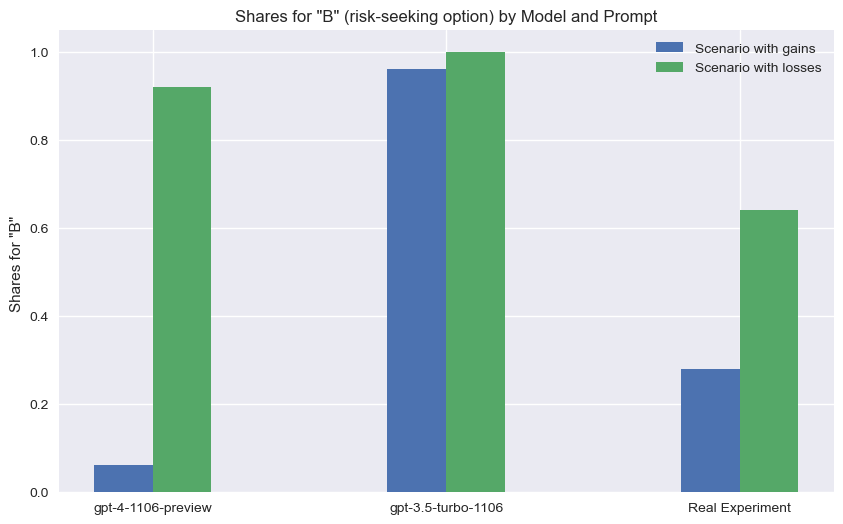

In [61]:
# Extract unique models
models = df['Model'].unique()

# Set up figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
bar_positions = np.arange(len(models))

# Plotting bars for 'B' for each prompt
for i, prompt in enumerate(df['Prompt'].unique()):
    values_B = df[df['Prompt'] == prompt]['B']
    scenario_label = 'Scenario with gains' if prompt == 1 else 'Scenario with losses'
    ax.bar(bar_positions + bar_width * i, values_B, width=bar_width, label=scenario_label)

# Calculate midpoints of the bar groups
midpoints = bar_positions + (bar_width * (len(df['Prompt'].unique()) - 1)) / 2

# Set x-axis ticks and labels to midpoints
ax.set_xticks(midpoints)
ax.set_xticklabels(models)
ax.set_ylabel('Shares for "B" ')

# Legend
ax.legend()

# Title
plt.title('Shares for "B" (risk-seeking option) by Model and Prompt')

# Show plot
plt.show()

Conclusion: GPT-4 is risk-averse for gains, but risk-seeking for losses, which is align with human behavior. GPT-3 prefers the risk-seeking options in both scenarios.